# Generalized coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

## Definition
For the linear models of the eye and arm, we consider a single-input single-output discrete-time system under control with the following state-update equation:
$$
\tilde{x}_{t+1} = A\tilde{x}_t+B\left (u_t+w_t \right)
$$  
where $\tilde{x}_t$ is the $n$-dimentional state at time $t$, $\tilde{x}_{t+1}$ is the $n$-dimentional state at time $t+dt$, $u_t$ the neural driving signal at time $t$, $w_t$ is a white noise with mean zero and variance $ku_t^2$, $A$ is a fixed $n \times n$ matrix and B is a $n \times 1$ vector both describing the dynamics of the system.

Here, A will be the following matrix:  

$$ A = 
\begin{bmatrix}
1 & dt & \frac{dt^2}{2} & \cdots & \frac{dt^n}{n!}\\
0 & 1 & dt & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots\\
0 & 0 & 0 & 1 & dt \\
0 & \cdots & \cdots & \cdots & 1-\frac{dt\beta}{m}
\end{bmatrix}
\textbf{ }\textbf{ }\textbf{ }\textbf{ }and\textbf{ }\textbf{ }\textbf{ }\textbf{ }
B = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ \frac{dt}{m}\end{bmatrix}
$$  
  
We choose this matrix since, according to the Taylor's formula:  
$ x\left (t+dt \right) = x\left (t \right) + dt\times \dot{x}\left (t \right) + \frac{dt^2}{2}\times \ddot{x}\left (t \right)+ \dots + \frac{dt^n}{n!}\times x^{(n)}\left (t \right) + \mathcal{o}\left(dt^n\right)
$
and  
$x^{(n)}\left (t+dt \right) = \left ( 1 - \frac{dt\beta}{m} \right)x^{(n)}\left (t \right) + \frac{dt}{m}\left (u \left (t\right) + w\left (t\right) \right)
$

In [3]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [4]:
beta = 100 
m = 1
dt = 0.001 # step time
n = 2 # number of coordinates
k = 0.0005 # kind of accuracy parameter: the smaller k is, the more accurate is the pointing

In [5]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt*beta/m
B[n-1] = dt/m

In [6]:
t_T = .05 # movement duration
t_R = .05 # post-movement duration
T = int(t_T/dt)
R = int(t_R/dt)
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.zeros(n) # starting point
xT = np.zeros(n) # ending point
xT[0] = 10
v = 20 # velocity of the target (deg/s)

## Mean and covariance matrix
$\tilde{x}_t = A\tilde{x}_{t-1}+B\left (u_{t-1}+w_{t-1} \right) \\
\tilde{x}_t = A \left (A\tilde{x}_{t-2}+B\left (u_{t-2}+w_{t-2} \right)\right) + B\left (u_{t-1}+w_{t-1} \right) \\
...\\
\tilde{x}_t = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}B \left (u_i+w_i \right)}
$
  
We deduce the mean:
$E\left [\tilde{x}_t \right] = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}Bu_i}$ since $E\left [w_t \right] = 0$.


Then, $cov\left [\tilde{x}_t\right ] = \sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T E\left [w_t^2 \right]} = k\sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T u_t^2}$


  
## Minimum-variance problem
Here, the problem we consider consists in minimizing the sum of the variance of the position after reaching the target. Let $V_t$ be the top-left value in the covariance matrix at time $t$. Then, we want to minimize $\sum \limits_{t=T+1}^{T+R}V_t +bias$. 

In [7]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,n,n))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])

In [8]:
def expectation(u, t):
    """Computation of the expectation of the state vector at time t, given u
    """
    if t == 0:
        return x0
    else:
        return (ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

In [9]:
def variance(u, t):
    """Computation of the variance of the state vector at time t, given u
    """
    return (m**2)*k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()

In [10]:
mult_v = np.array([1, 0.01]) # we select the level of each parameter in the cost function

In [11]:
def bias(u, t):
    """Computation of the bias of the state vector at time t, given u
    """
    return (((expectation(u, t)-(xT+np.array([v*t*dt,v])))**2)*mult_v).sum()

 
This can be formulated as a quadratic programming problem, which we solved using a gradient descent.

## Gradient descent

Let $\mathscr{C}$ be the cost function to minimize.  
That is, we want to find $\textbf{u}_{\textbf{opt}} = \underset{u_0, ..., u_{T+R}}{argmin} \left (\sum \limits_{t=T+1}^{T+R}V_t  + \sum \limits_{t=T}^{T+R}\|E\left [\tilde{x}_t\right] - x_T \|^2 \right )= \underset{u_0, ..., u_{T+R}}{argmin}\left(\mathscr{C}\left (\textbf{u}\right)\right)$.



In [12]:
def cost(u):
    def var1d(t):
        return(variance(u,t))
    var_vec = np.vectorize(var1d)
    def bias1d(t):
        return(bias(u,t))
    bias_vec = np.vectorize(bias1d)
    return var_vec(T+1+np.arange(R)).sum() + bias_vec(T+np.arange(R+1)).sum()

Iterating the following process, we will get the right $\textbf{u}_{\textbf{opt}}$ :  
$\forall i \in \left \{ 0, ..., T+R-1 \right \} : u_i = u_i - \eta \times \frac{\partial \mathscr{C}\left(\textbf{u}\right)}{\partial u_i}$

In [13]:
def cost_deriv(u, i):
    """Derivative of the cost function with respect to u_i
    """
    if i < T:
        return (2*np.transpose(ci[:,(T-i-1):(T+R-i)])*np.array([((expectation(u,t)-xT-np.array([v*t*dt,v]))*mult_v).tolist() for t in (T+np.arange(R+1))])).sum() + 2*(m**2)*k*u[i]*(ci0_array[(T+1-i-1):(T+R-i)]**2).sum()
    else:
        return (2*np.transpose(ci[:,0:(T+R-i)])*np.array([((expectation(u,t)-xT-np.array([v*t*dt,v]))*mult_v).tolist() for t in (i+1+np.arange(R+T-i))])).sum() + 2*(m**2)*k*u[i]*(ci0_array[0:(T+R-i)]**2).sum()

In [18]:
niter = 2000000
eta = 1000000

In [19]:
import time

In [20]:
ubang = np.array([ 30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
        30091.22213195,  30091.22213195,  30091.22213195,  30091.22213195,
       -30091.22213195, -30091.22213195, -30091.22213195, -30091.22213195,
       -30091.22213195, -30091.22213195,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ,   2000.        ,   2000.        ,   2000.        ,
         2000.        ])

In [21]:
#np.random.seed(42)
#u = np.random.uniform(-5, 5, T+R+1)
#u[T:T+R+1]=0
debut = time.time()
#u = 20000* np.ones(T+R+1)
#u[T-4:T] *= -3
#u[T:(T+R+1)] = 0
u = ubang.copy()
a = np.zeros((niter+1, T+R+1)) # To save the evolution of the values of u at each iteration
a[0, :] = u.copy()
for i_iter in np.arange(niter):
    u_old = u.copy()
    u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv(u_old, i) for i in np.arange(T+R)])
    a[i_iter+1, :] = u.copy()
fin = time.time()

In [22]:
np.array([cost_deriv(u, i) for i in np.arange(T+R)])

array([ -1.78685987e-12,  -1.78001451e-12,  -1.77237006e-12,
        -1.76382855e-12,  -1.75427891e-12,  -1.74359497e-12,
        -1.73163308e-12,  -1.71822940e-12,  -1.70319647e-12,
        -1.68631939e-12,  -1.66735096e-12,  -1.64600608e-12,
        -1.62195477e-12,  -1.59481389e-12,  -1.56413686e-12,
        -1.52940120e-12,  -1.48999309e-12,  -1.44518834e-12,
        -1.39412863e-12,  -1.33579187e-12,  -1.26895493e-12,
        -1.19214647e-12,  -1.10358704e-12,  -1.00111247e-12,
        -8.82075305e-13,  -7.43217244e-13,  -5.80502953e-13,
        -3.88902150e-13,  -1.62101946e-13,   1.07875655e-13,
         4.31185770e-13,   8.20851379e-13,   1.29370173e-12,
         1.87165702e-12,   2.58350038e-12,   3.46733992e-12,
         4.57405479e-12,   5.97215186e-12,   7.75465422e-12,
         1.00489267e-11,   1.30307532e-11,   1.69445608e-11,
         2.21324900e-11,   2.90760482e-11,  -3.03643114e-11,
        -2.83139866e-11,  -2.39288376e-11,  -1.58438546e-11,
        -2.03188638e-12,

In [33]:
(fin-debut)

173044.64545035362

In [24]:
u

array([ 33275.12398939,  33246.28195613,  33214.21715285,  33178.56724108,
        33138.9286222 ,  33094.85161734,  33045.83505606,  32991.32019492,
        32930.68387521,  32863.23081493,  32788.18491391,  32704.67943126,
        32611.74587122,  32508.30138624,  32393.13447291,  32264.88869753,
        32122.04414054,  31962.89619246,  31785.53126512,  31587.79889896,
        31367.27964565,  31121.24798243,  30846.62936351,  30539.9503294 ,
        30197.28036838,  29814.16394515,  29385.54076758,  28905.65193743,
        28367.92910512,  27764.86309754,  27087.84768247,  26326.99313599,
        25470.90304856,  24506.40629112,  23418.23421019,  22188.63087641,
        20796.88153008,  19218.74123625,  17425.74223891,  15384.35478583,
        13054.97275169,  10390.69317799,   7335.85972039,   3824.34733794,
         -239.23579769,  -4917.48425343, -10335.12373318, -16621.56762719,
       -23926.71037616, -32420.57582401,   1994.43046628,   2000.05835621,
         2000.05767001,  

In [25]:
i_iter

1999999

Then, we draw $\text{u}$, that is, the evolution of the control signal during the experiment.

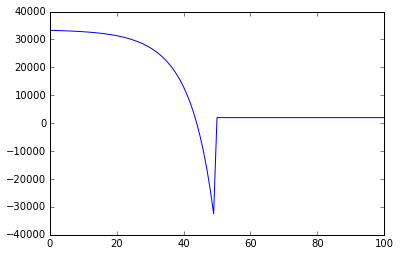

In [26]:
plt.plot(u)

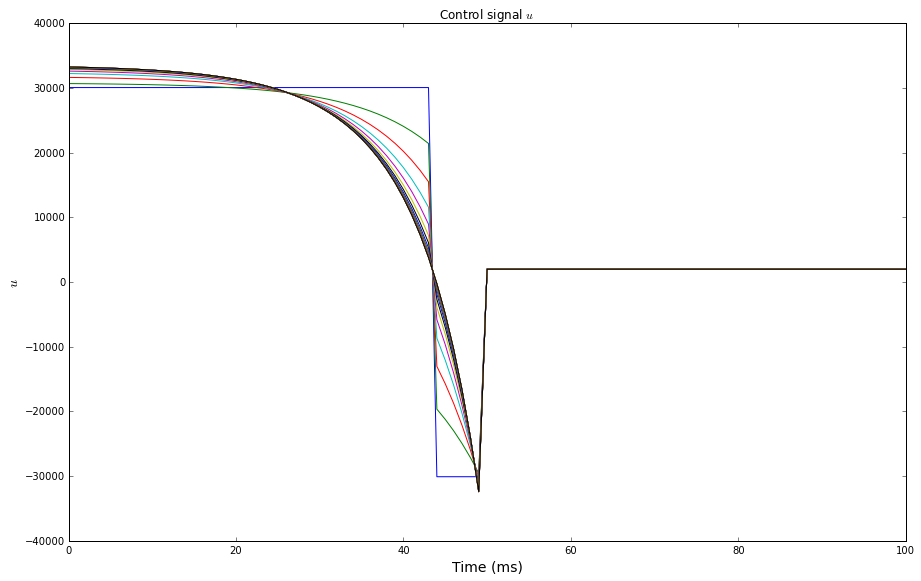

In [34]:
plot_signal(a, 100000, 2000000, 0.05, 0.05, 0.001)

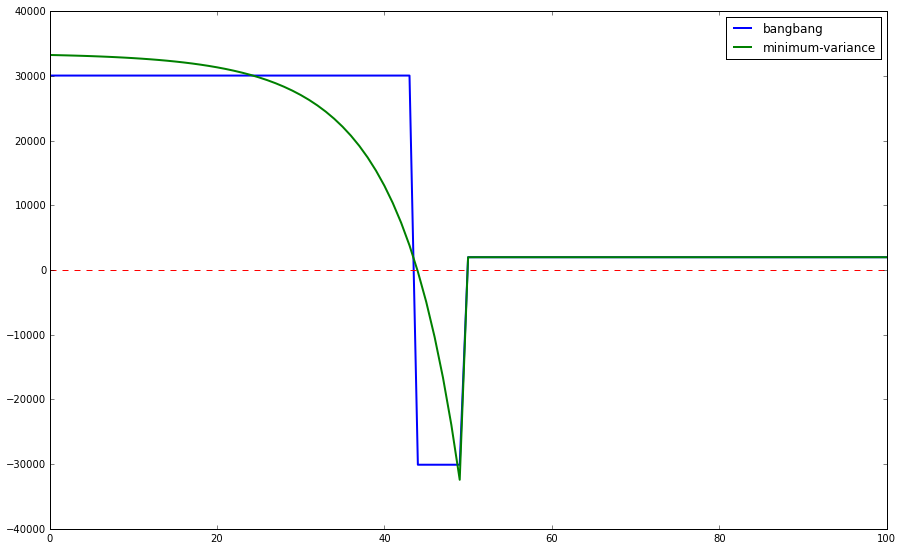

In [51]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, a[0], lw=2, label="bangbang")
ax.plot(time_ms, a[niter], lw=2, label="minimum-variance")
ax.plot([0,100],[0,0],'r--')
ax.legend()

In [29]:
position = np.zeros((niter+1,T+R+1))
velocity = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        mean = expectation(a[i,:], j)
        position[i,j] = mean[0]
        velocity[i,j] = mean[1]

In [30]:
position[0] = np.array([  0.        ,   0.01455638,   0.05636313,   0.12282701,
         0.21160161,   0.32056377,   0.4477924 ,   0.5915492 ,
         0.75026132,   0.92250557,   1.1069942 ,   1.30256199,
         1.50815464,   1.72281814,   1.94568929,   2.17598703,
         2.41300462,   2.6561026 ,   2.90470233,   3.15828025,
         3.41636262,   3.67852079,   3.9443669 ,   4.21354999,
         4.48575251,   4.76068711,   5.03809382,   5.31773736,
         5.59940489,   5.8829038 ,   6.1680598 ,   6.4547152 ,
         6.74272732,   7.03196705,   7.32231756,   7.61367315,
         7.90593817,   8.19902609,   8.49285858,   8.7873648 ,
         9.08248064,   9.37814807,   9.67431461,   9.97093276,
        10.16719362,  10.42273527,  10.62532332,  10.77999699,
        10.89131593,  10.96340589,  11.        ,  11.02      ,
        11.04      ,  11.06      ,  11.08      ,  11.1       ,
        11.12      ,  11.14      ,  11.16      ,  11.18      ,
        11.2       ,  11.22      ,  11.24      ,  11.26      ,
        11.28      ,  11.3       ,  11.32      ,  11.34      ,
        11.36      ,  11.38      ,  11.4       ,  11.42      ,
        11.44      ,  11.46      ,  11.48      ,  11.5       ,
        11.52      ,  11.54      ,  11.56      ,  11.58      ,
        11.6       ,  11.62      ,  11.64      ,  11.66      ,
        11.68      ,  11.7       ,  11.72      ,  11.74      ,
        11.76      ,  11.78      ,  11.8       ,  11.82      ,
        11.84      ,  11.86      ,  11.88      ,  11.9       ,
        11.92      ,  11.94      ,  11.96      ,  11.98      ,  12.        ])

In [31]:
velocity[0] = np.array([   0.        ,   28.63558393,   54.54613175,   77.99096494,
         99.20472727,  118.39973321,  135.76809282,  151.48363448,
        165.70364462,  178.57044189,  190.2128015 ,  200.74724411,
        210.27920196,  218.9040741 ,  226.70818113,  233.76962919,
        240.15909161,  245.9405163 ,  251.17176568,  255.90519587,
        260.18818062,  264.06358548,  267.57019681,  270.74310995,
        273.61408048,  276.21184205,  278.56239391,  280.6892612 ,
        282.6137303 ,  284.35506195,  285.93068398,  287.35636576,
        288.64637597,  289.81362549,  290.86979652,  291.8254596 ,
        292.6901793 ,  293.47261005,  294.18058267,  294.82118278,
        295.40082174,  295.92530075,  296.39986899,  296.82927609,
        283.82797042,  228.182584  ,  177.83255622,  132.27396709,
         91.05085093,   53.75063294,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,   20.        ])

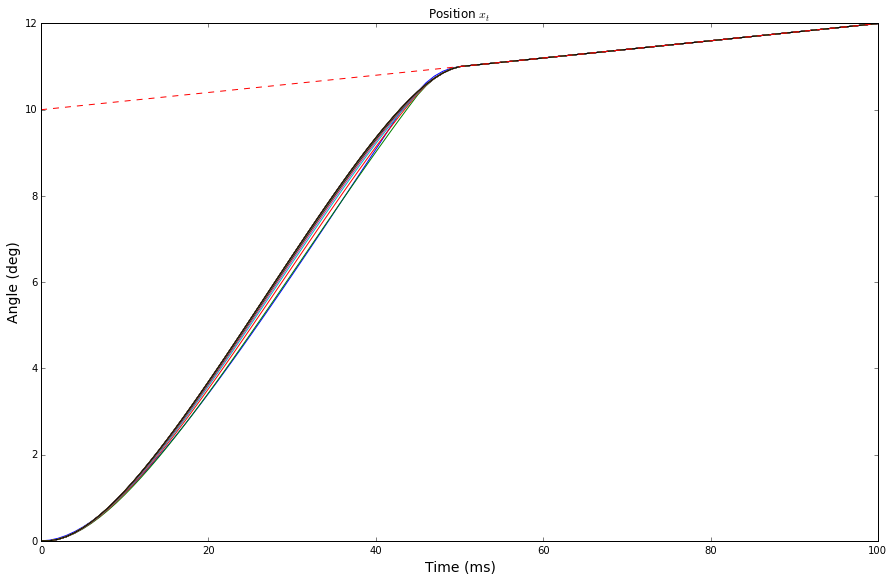

In [36]:
plot_position(position, 100000, 2000000, 0.05, 0.05, 0.001)
plt.plot(np.linspace(0,100,T+R+1),xT[0]+v*np.linspace(0,100,T+R+1)/1000,'r--')


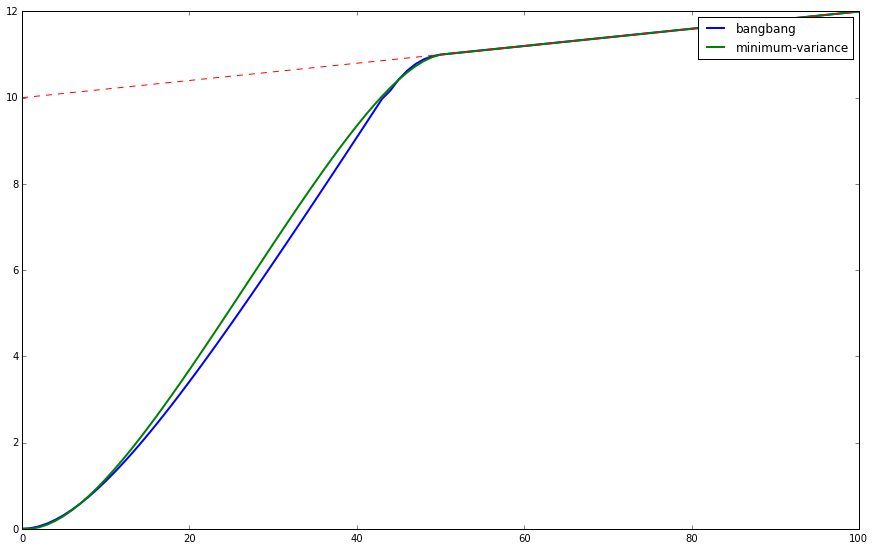

In [50]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, position[0], lw=2, label="bangbang")
ax.plot(time_ms, position[niter], lw=2, label="minimum-variance")
ax.plot(np.linspace(0,100,T+R+1),xT[0]+v*np.linspace(0,100,T+R+1)/1000,'r--')
ax.legend()


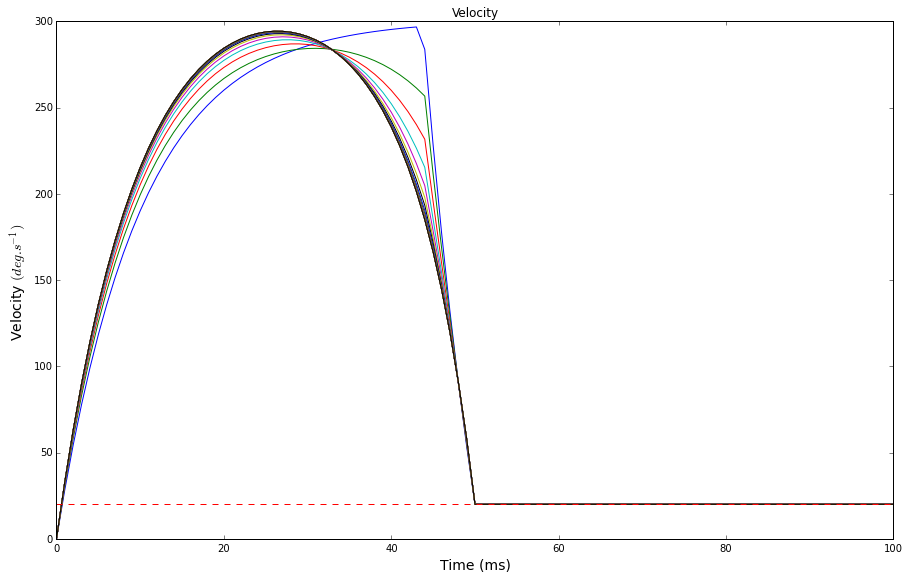

In [38]:
plot_velocity(velocity, 100000, 2000000,  0.05, 0.05, 0.001)
plt.plot(np.linspace(0,100,T+R+1),v*np.ones(T+R+1),'r--')

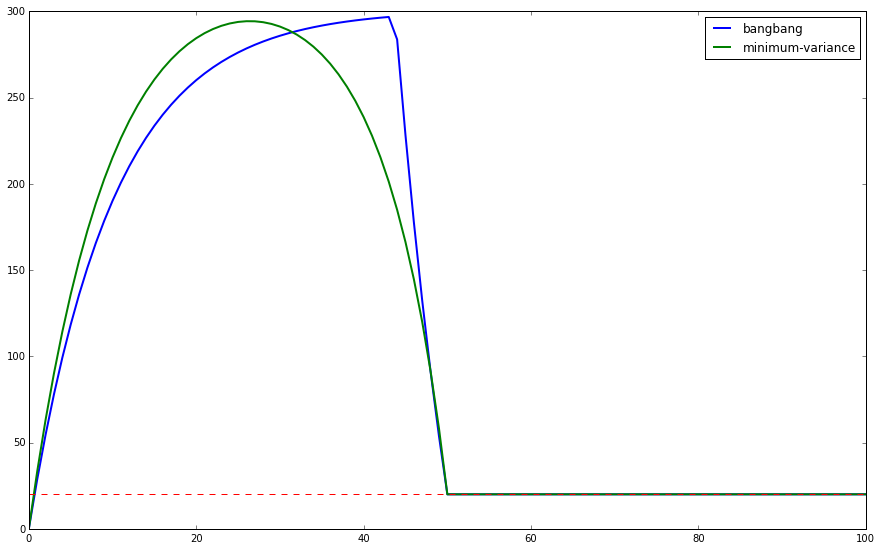

In [52]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, velocity[0], lw=2, label="bangbang")
ax.plot(time_ms, velocity[niter], lw=2, label="minimum-variance")
ax.plot(np.linspace(0,100,T+R+1),v*np.ones(T+R+1),'r--')
ax.legend()

In [42]:
variancev = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        variancev[i,j] = variance(a[i,:], j)

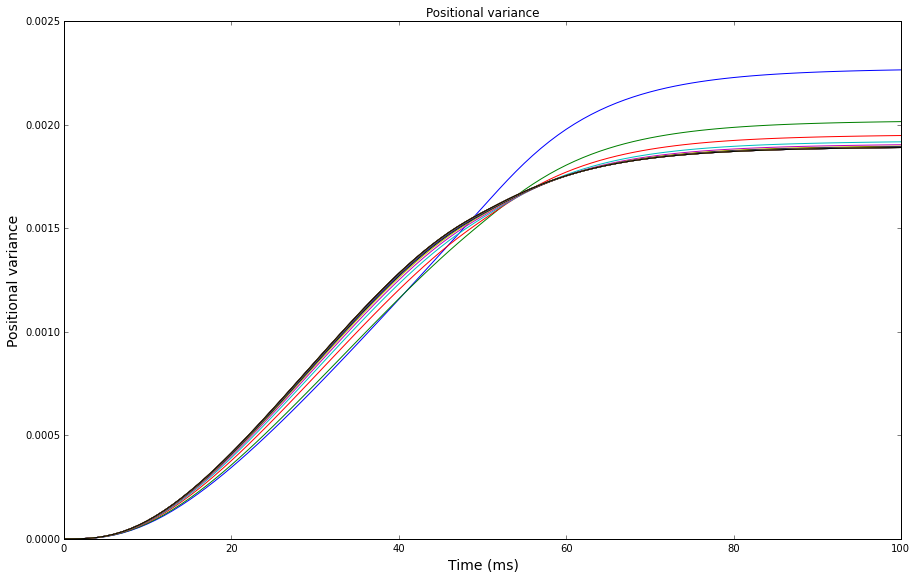

In [43]:
plot_variance(variancev, 100000, 2000000, 0.05, 0.05, 0.001)

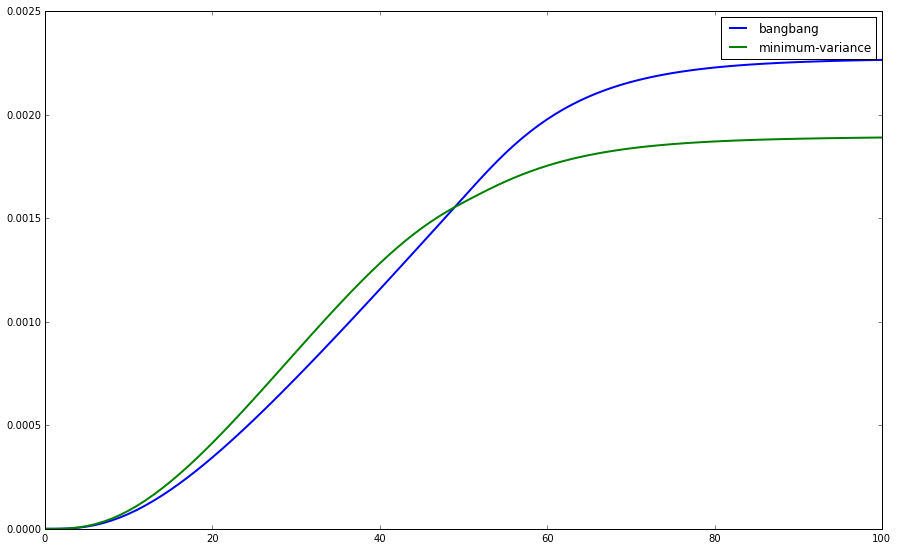

In [53]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, variancev[0], lw=2, label="bangbang")
ax.plot(time_ms, variancev[niter], lw=2, label="minimum-variance")
ax.legend()

In [45]:
cost_p = np.zeros(niter+1)

for i in np.arange(niter+1):
    cost_p[i] = cost(a[i])

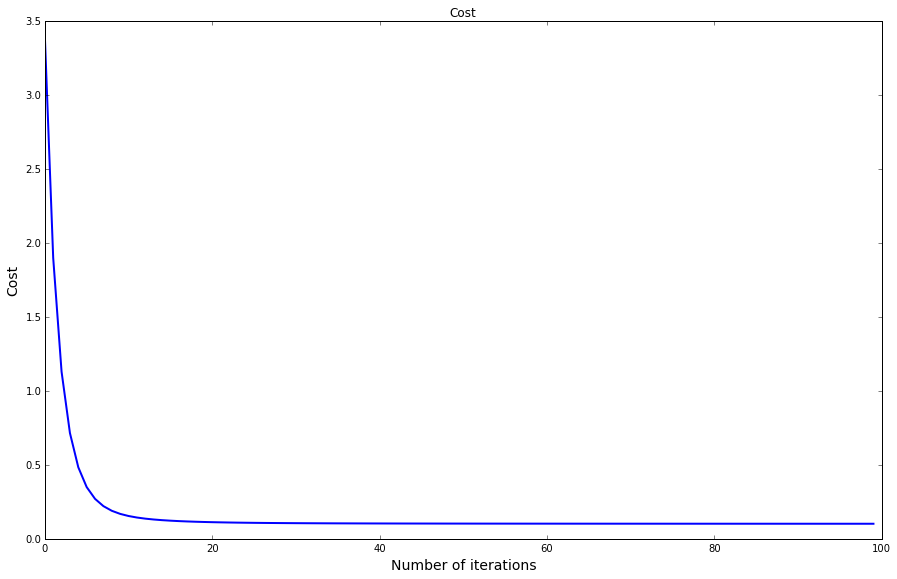

In [55]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(cost_p[0:100], '-', lw = 2)
ax.set_title('Cost')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)


Finally, we trace the position at time T for each iteration.

In [56]:
positionT = np.zeros(niter+1)

for i in np.arange(niter+1):
    positionT[i] = (expectation(a[i], T))[0]

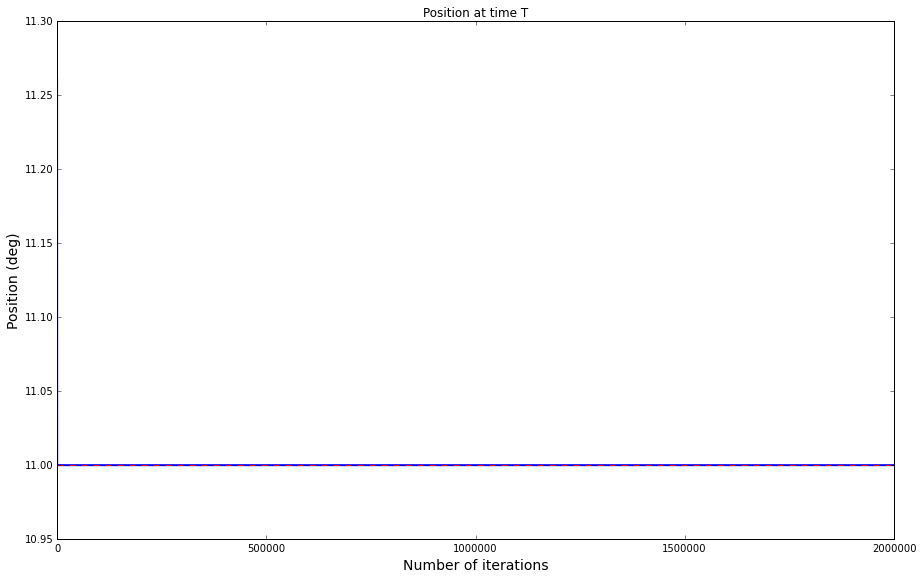

In [57]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(positionT, '-', lw=2)
ax.set_title('Position at time T')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Position (deg)', fontsize=14)
ax.plot([0,niter],[xT[0]+v*t_T ,xT[0]+v*t_T],'r--')
